## First, we need to calibrate the camera to get the intrinsic parameters.

In [1]:
import cv2
import numpy as np
import glob

def calibrateCamera(calibrationImagesPath, square_size=0.018):  
    # Set the size of the chessboard (number of inner corners)
    chessboardSize = (9, 6)
    
    # Prepare 3D points of the chessboard (3D object points)
    objP = np.zeros((chessboardSize[0] * chessboardSize[1], 3), np.float32)
    
    # Generate the 3D points for the chessboard (multiply by square_size to scale it)
    objP[:, :2] = np.mgrid[0:chessboardSize[0], 0:chessboardSize[1]].T.reshape(-1, 2)
    objP *= square_size  # Apply the square_size to convert to real-world coordinates
    
    # Store 3D points and 2D points of all images
    objPoints = []  # 3D points in the real world
    imgPoints = []  # 2D points in the image
    
    # Read all calibration images
    images = glob.glob(calibrationImagesPath + '/*.jpg')
    for fName in images:
        img = cv2.imread(fName)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Find chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, chessboardSize, None)
        
        if ret:
            objPoints.append(objP)
            imgPoints.append(corners)
            
            # Visualize corners
            cv2.drawChessboardCorners(img, chessboardSize, corners, ret)
            cv2.imshow('img', img)
            cv2.waitKey(100)
    
    cv2.destroyAllWindows()
    
    # Calibrate the camera
    ret, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(
        objPoints, imgPoints, gray.shape[::-1], None, None
    )
    
    return cameraMatrix, distCoeffs

# Use the function
calibrationImagesPath = 'calibration'
# 0.018m is the size of the square in the calibration images
cameraMatrix, distCoeffs = calibrateCamera(calibrationImagesPath, square_size=0.018)  

print("Camera intrinsic matrix:\n", cameraMatrix)
print("Distortion coefficients:\n", distCoeffs)


Camera intrinsic matrix:
 [[3.21213577e+03 0.00000000e+00 2.04268055e+03]
 [0.00000000e+00 3.20530786e+03 1.51530656e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion coefficients:
 [[ 8.96553340e-02 -5.57785712e-01  1.96393038e-03  1.07377900e-03
   1.10837828e+00]]


# Then, generate the bird's-eye view of the input image.

Homography matrix:
 [[ 7.71717730e+00  1.17953429e+01 -9.65974598e+03]
 [-2.56002703e-01  2.13743306e+01 -1.19289641e+04]
 [ 9.83385048e-05  1.22567548e-03  1.00000000e+00]]


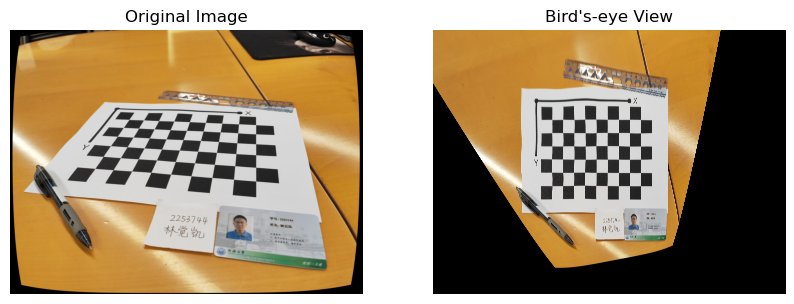

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def generateBirdseyeView(inputImagePath, outputImagePath, cameraMatrix, distCoeffs):
    # Read the input image
    image = cv2.imread(inputImagePath)
    if image is None:
        print("Unable to read the input image. Please check the path.")
        return
    
    # Undistort the image
    h, w = image.shape[:2]
    imageUndistorted = cv2.undistort(image, cameraMatrix, distCoeffs, None)
    
    # Chessboard size
    chessboardSize = (9, 6)
    
    # Find chessboard corners
    gray = cv2.cvtColor(imageUndistorted, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, chessboardSize, None)
    
    if not ret:
        print("Failed to find chessboard corners, please check the input image.")
        return
    
    # Use the four corners of the chessboard as source points
    srcPoints = np.float32([corners[0], corners[chessboardSize[0]-1],
                            corners[-chessboardSize[0]], corners[-1]])
    
    # Adjust destination points to keep the top-left corner in the original position
    leftTop = corners[0].ravel() * 4
    dstPoints = np.float32([leftTop, 
                            [leftTop[0] + w, leftTop[1]], 
                            [leftTop[0], leftTop[1] + h], 
                            [leftTop[0] + w, leftTop[1] + h]])
    
    # Compute the homography matrix and apply perspective transformation
    H = cv2.getPerspectiveTransform(srcPoints, dstPoints)
    print("Homography matrix:\n", H)  # Output the homography matrix
    birdImage = cv2.warpPerspective(imageUndistorted, H, (w*4, h*4))
    
    # Save the bird's-eye view image
    cv2.imwrite(outputImagePath, birdImage)
    
    # Display the original and bird's-eye view images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(imageUndistorted, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('Bird\'s-eye View')
    plt.imshow(cv2.cvtColor(birdImage, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    plt.show()

# Use the function
inputImagePath = 'birdview/input.jpg'
outputImagePath = 'birdview/output.jpg'
generateBirdseyeView(inputImagePath, outputImagePath, cameraMatrix, distCoeffs)